# 16 - Faster busstop and store-to-store distance calculations and better distance features

In addition to the store-to-busstop distance calculation speed optimization, the store-to-store distance calculation has also been optimized the same way. The combined runtime of both distance calculations has been brought down to approximately 1 hour. This allowed us to more thoroughly test different combinations of the distance features to find the one producing the best results. 

By doing this, we were able to test multiple different combinations of radiuses for both store-to-store and store-to-busstop distances, and used the one with the best score.

In addition, we mad sure that the result was reproducable by including "max_models" and "seed" as training parameters.

In [22]:
# Import and init h2o lib. Running on java
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 hours 48 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,1 month and 23 days
H2O_cluster_name:,H2O_from_python_jupyter_okcnnb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,931 Mb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


### Read all data

In [23]:
import pandas as pd

stores_train = pd.read_csv('data/stores_train.csv', engine="python", error_bad_lines=False, encoding='utf-8')
stores_test = pd.read_csv('data/stores_test.csv', engine="python", error_bad_lines=False, encoding='utf-8')
stores_extra = pd.read_csv('data/stores_extra.csv', engine="python", error_bad_lines=False, encoding='utf-8')
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv', engine="python", error_bad_lines=False, encoding='utf-8')
busstops_norway = pd.read_csv('data/busstops_norway.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_age_distribution = pd.read_csv('data/grunnkrets_age_distribution.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_households_num_persons = pd.read_csv('data/grunnkrets_households_num_persons.csv', engine="python", error_bad_lines=False, encoding='utf-8')
grunnkrets_income_households = pd.read_csv('data/grunnkrets_income_households.csv', engine="python", error_bad_lines=False, encoding='utf-8')

Skipping line 12465: unexpected end of data


## Feature engineering: Calculate distances between all stores and busstops

Create a dataset with one row for each store (both from stores_train and stores_test) containing information about the amount of busstops and different stores nearby. This dataframe can be used as a look-up table for when generating the final dataset to train on.

#### haversine latlong distance calculation

In [3]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371 * c
    return round(km, 3)

In [4]:
from tqdm import tqdm
import numpy as np

# Extract busstop coordinates and create df with only ['busstop_id', 'busstop_lat', 'busstop_lon']
df_busstop_coordinates = busstops_norway.copy()
df_busstop_coordinates['lonlat_list'] = busstops_norway['geometry'].map(lambda x: x[6:-1].split(' '))
df_busstop_coordinates['busstop_lat'] = df_busstop_coordinates['lonlat_list'].map(lambda x: float(x[1]))
df_busstop_coordinates['busstop_lon'] = df_busstop_coordinates['lonlat_list'].map(lambda x: float(x[0]))
df_busstop_coordinates = df_busstop_coordinates[['busstop_id', 'busstop_lat', 'busstop_lon']]

# Initialize the df_stores_distances dataframe with all stores from both stores_train and stores_test. Only with ['store_id', 'lat', 'lon'] for now
df_stores_distances = stores_train[['store_id', 'lat', 'lon']].append(stores_test[['store_id', 'lat', 'lon']], ignore_index=True)

# Create temp column to hold all calculated busstop distances in long lists
df_stores_distances['busstop_distances'] = pd.Series(dtype='object')

# Iterate over all stores in 'df_stores_distances' (stores used for training and testing)
for index, store in tqdm(df_stores_distances.iterrows()):
    #if index == 10: break
    
    # Remove busstops that are more than half a degree lat or half a degree longitude away to reduce computational strain
    df_busstop_coordinates['store_lat'] = store['lat']
    df_busstop_coordinates['store_lon'] = store['lon']
    df_relevant_busstops = df_busstop_coordinates[(abs(df_busstop_coordinates['store_lat'] - df_busstop_coordinates['busstop_lat']) < 0.5) & (abs(df_busstop_coordinates['store_lon'] - df_busstop_coordinates['busstop_lon']) < 0.5)]
    
    # Calculate all distances from the current 'store' to each busstop in 'df_relevant_busstops'. Then, assign distances to relevant cell in 'df_stores_distances'
    list_of_distances = np.array(df_relevant_busstops.apply(lambda row: haversine(store['lat'], store['lon'], row['busstop_lat'], row['busstop_lon']), axis=1))
    df_stores_distances.at[index, 'busstop_distances'] = list_of_distances
    
    # Find number of busstops within certain distances and populate relevant columns
    df_stores_distances.at[index, 'busstops_within_0_5_km'] = len(list(filter(lambda x: x < 0.5, df_stores_distances.at[index, 'busstop_distances'])))
    df_stores_distances.at[index, 'busstops_within_1_km'] = len(list(filter(lambda x: x < 1, df_stores_distances.at[index, 'busstop_distances'])))
    df_stores_distances.at[index, 'busstops_within_3_km'] = len(list(filter(lambda x: x < 3, df_stores_distances.at[index, 'busstop_distances'])))
    df_stores_distances.at[index, 'busstops_within_5_km'] = len(list(filter(lambda x: x < 5, df_stores_distances.at[index, 'busstop_distances'])))
    df_stores_distances.at[index, 'busstops_within_10_km'] = len(list(filter(lambda x: x < 10, df_stores_distances.at[index, 'busstop_distances'])))

# The dataframe 'df_stores_distances' can now be used as a lookup-table to find number of nearby busstops for each store
df_stores_distances

21436it [28:48, 12.40it/s]


,store_id,lat,lon,busstop_distances,busstops_within_0_5_km,busstops_within_1_km,busstops_within_3_km,busstops_within_5_km,busstops_within_10_km
0,983540538-974187930-44774,59.743104,10.204928,"[70.566, 64.002, 63.796, 55.469, 63.691, 60.79...",0.0,10.0,72.0,145.0,429.0
1,987074191-973117734-44755,59.913759,10.734031,"[5.215, 5.221, 5.226, 5.237, 5.241, 2.792, 2.7...",16.0,30.0,172.0,328.0,865.0
2,984890265-981157303-64491,60.164751,10.254656,"[57.171, 57.171, 56.917, 56.838, 37.002, 53.34...",9.0,14.0,48.0,94.0,193.0
3,914057442-992924179-126912,67.283669,14.379796,"[42.919, 42.909, 24.212, 41.574, 21.112, 7.203...",5.0,11.0,43.0,90.0,139.0
4,913018583-913063538-668469,63.358068,10.374832,"[37.087, 37.087, 16.381, 16.557, 17.093, 17.21...",8.0,29.0,150.0,284.0,687.0
...,...,...,...,...,...,...,...,...,...
21431,917323003-917383529-844309,59.259575,5.325813,"[35.09, 50.967, 49.634, 47.725, 61.199, 61.186...",4.0,9.0,25.0,49.0,129.0
21432,917353379-917411824-845904,58.976219,5.721546,"[34.243, 10.63, 10.6, 10.34, 10.312, 11.298, 5...",7.0,28.0,227.0,449.0,815.0
21433,917072302-917089248-833647,59.928330,11.163202,"[42.818, 42.816, 42.814, 42.811, 42.809, 50.09...",5.0,6.0,31.0,48.0,104.0
21434,916960557-916993161-829908,60.445790,5.161587,"[24.034, 24.428, 22.436, 10.54, 42.328, 17.934...",4.0,8.0,38.0,84.0,399.0


## Stores distances engineering

In [5]:
# Create dataframe with all provided stores and their coordinates ['store_id', 'lat', 'lon']
df_all_stores_coordinates = stores_train[['store_id', 'lat', 'lon']].append(stores_test[['store_id', 'lat', 'lon']], ignore_index=True).append(stores_extra[['store_id', 'lat', 'lon']], ignore_index=True)

# The same 'df_stores_distances' as before will be used to store the distances between stores
df_stores_distances = df_stores_distances

# Create temp column to hold all calculated store-to-store distances in long lists
df_stores_distances['store_to_store_distances'] = pd.Series(dtype='object')

# Iterate over all stores in 'df_stores_distances' (stores used for training and testing)
for index, store in tqdm(df_stores_distances.iterrows()):
    #if index == 10: break
    
    # Remove stores that are more than half a degree lat or half a degree longitude away to reduce computational strain
    df_all_stores_coordinates['store_lat'] = store['lat']
    df_all_stores_coordinates['store_lon'] = store['lon']
    df_relevant_stores = df_all_stores_coordinates[(abs(df_all_stores_coordinates['store_lat'] - df_all_stores_coordinates['lat']) < 0.5) & (abs(df_all_stores_coordinates['store_lon'] - df_all_stores_coordinates['lon']) < 0.5)]
    
    # Calculate all distances from the current 'store' to each other store in 'df_relevant_busstops'. Then, assign distances to relevant cell in 'df_stores_distances'
    list_of_distances = np.array(df_relevant_stores.apply(lambda row: haversine(store['lat'], store['lon'], row['lat'], row['lon']), axis=1))
    df_stores_distances.at[index, 'store_to_store_distances'] = list_of_distances
    
    # Find number of other stores within certain distances and populate relevant columns
    df_stores_distances.at[index, 'stores_within_0_5_km'] = len(list(filter(lambda x: x < 0.5, df_stores_distances.at[index, 'store_to_store_distances'])))
    df_stores_distances.at[index, 'stores_within_1_km'] = len(list(filter(lambda x: x < 1, df_stores_distances.at[index, 'store_to_store_distances'])))
    df_stores_distances.at[index, 'stores_within_3_km'] = len(list(filter(lambda x: x < 3, df_stores_distances.at[index, 'store_to_store_distances'])))
    df_stores_distances.at[index, 'stores_within_5_km'] = len(list(filter(lambda x: x < 5, df_stores_distances.at[index, 'store_to_store_distances'])))
    df_stores_distances.at[index, 'stores_within_10_km'] = len(list(filter(lambda x: x < 10, df_stores_distances.at[index, 'store_to_store_distances'])))

# The dataframe 'df_stores_distances' can now be used as a lookup-table to find number of nearby other stores for each store
df_stores_distances

21436it [40:30,  8.82it/s]


,store_id,lat,lon,busstop_distances,busstops_within_0_5_km,busstops_within_1_km,busstops_within_3_km,busstops_within_5_km,busstops_within_10_km,store_to_store_distances,stores_within_0_5_km,stores_within_1_km,stores_within_3_km,stores_within_5_km,stores_within_10_km
0,983540538-974187930-44774,59.743104,10.204928,"[70.566, 64.002, 63.796, 55.469, 63.691, 60.79...",0.0,10.0,72.0,145.0,429.0,"[0.0, 46.47, 56.881, 58.81, 58.133, 31.476, 56...",257.0,371.0,532.0,591.0,894.0
1,987074191-973117734-44755,59.913759,10.734031,"[5.215, 5.221, 5.226, 5.237, 5.241, 2.792, 2.7...",16.0,30.0,172.0,328.0,865.0,"[0.0, 59.953, 24.266, 3.233, 2.988, 1.831, 2.0...",241.0,822.0,3339.0,4442.0,5884.0
2,984890265-981157303-64491,60.164751,10.254656,"[57.171, 57.171, 56.917, 56.838, 37.002, 53.34...",9.0,14.0,48.0,94.0,193.0,"[46.47, 59.953, 0.0, 61.558, 58.062, 60.778, 5...",159.0,174.0,258.0,261.0,289.0
3,914057442-992924179-126912,67.283669,14.379796,"[42.919, 42.909, 24.212, 41.574, 21.112, 7.203...",5.0,11.0,43.0,90.0,139.0,"[0.0, 4.809, 0.264, 1.124, 0.216, 0.037, 21.71...",192.0,252.0,308.0,461.0,485.0
4,913018583-913063538-668469,63.358068,10.374832,"[37.087, 37.087, 16.381, 16.557, 17.093, 17.21...",8.0,29.0,150.0,284.0,687.0,"[0.0, 5.683, 8.753, 8.572, 18.066, 12.297, 8.2...",51.0,156.0,272.0,353.0,1451.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21431,917323003-917383529-844309,59.259575,5.325813,"[35.09, 50.967, 49.634, 47.725, 61.199, 61.186...",4.0,9.0,25.0,49.0,129.0,"[55.341, 55.272, 55.747, 56.408, 58.05, 75.473...",1.0,1.0,5.0,67.0,90.0
21432,917353379-917411824-845904,58.976219,5.721546,"[34.243, 10.63, 10.6, 10.34, 10.312, 11.298, 5...",7.0,28.0,227.0,449.0,815.0,"[1.311, 1.242, 1.815, 2.512, 9.166, 23.419, 13...",11.0,54.0,661.0,949.0,1342.0
21433,917072302-917089248-833647,59.928330,11.163202,"[42.818, 42.816, 42.814, 42.811, 42.809, 50.09...",5.0,6.0,31.0,48.0,104.0,"[47.748, 23.484, 44.545, 44.96, 45.917, 49.719...",27.0,31.0,39.0,41.0,49.0
21434,916960557-916993161-829908,60.445790,5.161587,"[24.034, 24.428, 22.436, 10.54, 42.328, 17.934...",4.0,8.0,38.0,84.0,399.0,"[18.197, 19.022, 18.701, 10.529, 33.507, 23.87...",3.0,7.0,10.0,25.0,231.0


### Attach busstop distance and store-to-store distance columns to main dataset

In [54]:
columns_to_add = df_stores_distances[['store_id',
                                      'busstops_within_0_5_km',
                                      'busstops_within_1_km',
                                      'busstops_within_3_km',
                                      'busstops_within_5_km',
                                      'busstops_within_10_km',
                                      'stores_within_0_5_km',
                                      'stores_within_1_km',
                                      'stores_within_3_km',
                                      'stores_within_5_km',
                                      'stores_within_10_km',
                                     ]]

merged = stores_train.merge(columns_to_add,  how='left', on='store_id')
merged_test = stores_test.merge(columns_to_add,  how='left', on='store_id')

list(merged.columns)

['store_id',
 'year',
 'store_name',
 'plaace_hierarchy_id',
 'sales_channel_name',
 'grunnkrets_id',
 'address',
 'lat',
 'lon',
 'chain_name',
 'mall_name',
 'revenue',
 'busstops_within_0_5_km',
 'busstops_within_1_km',
 'busstops_within_3_km',
 'busstops_within_5_km',
 'busstops_within_10_km',
 'stores_within_0_5_km',
 'stores_within_1_km',
 'stores_within_3_km',
 'stores_within_5_km',
 'stores_within_10_km']

## revenue feature engineering

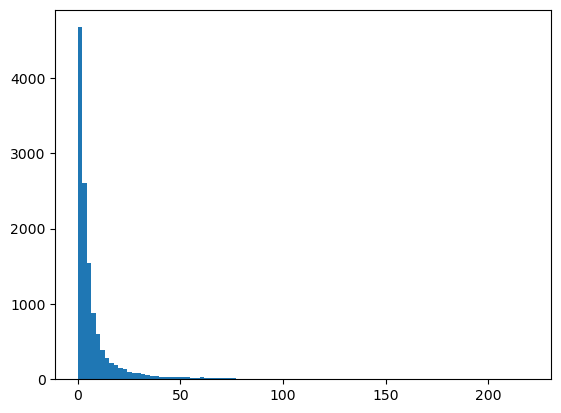

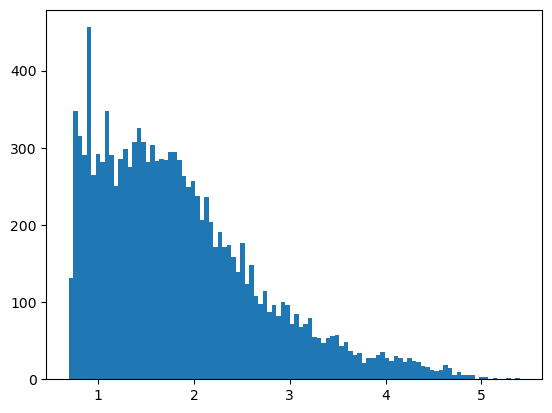

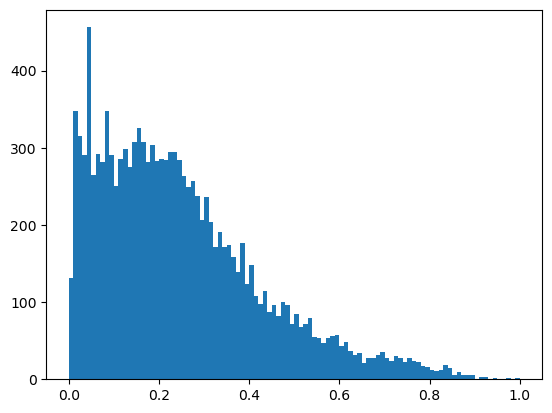

In [55]:
import matplotlib.pyplot as plt

# Perform log transform on revenue
merged['revenue'] = merged['revenue'].map(lambda x: np.log(x+2))
plt.hist(merged['revenue'], bins=100)
plt.show()

# Normalize revenue between 0 and 1
min_revenue, max_revenue = merged['revenue'].min(), merged['revenue'].max()
merged['revenue'] = (merged['revenue'] - min_revenue) / (max_revenue - min_revenue)
plt.hist(merged['revenue'], bins=100)
plt.show()

# Inverse normalization
#merged['revenue'] = merged['revenue'] * (max_revenue - min_revenue) + min_revenue
#plt.hist(merged['revenue'], bins=100)
#plt.show()

# Inverse log transform
#merged['revenue'] = np.exp(merged['revenue'])
#plt.hist(merged['revenue'], bins=100)
#plt.show()

### Building a Model


In [56]:
df = h2o.H2OFrame(merged)
df_test = h2o.H2OFrame(merged_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [57]:
# Setting features as factor
catagorical_columns = ['store_name',
                       'plaace_hierarchy_id',
                       'sales_channel_name',
                       'grunnkrets_id',
                       'address',
                       'chain_name',
                       'mall_name']

for column in catagorical_columns:
    if column == 'lv2' or column == 'lv3' or column == 'lv4':
        continue
    df[column] = df[column].asfactor()
    df_test[column] = df_test[column].asfactor()

In [58]:
# Removing labels from train set
y = "revenue"
x = df.columns
x.remove(y)

In [59]:
# Running fit/training on train set with cross validation n=5
aml = H2OAutoML(seed = 1)
aml.train(x = x, y = y, training_frame = df)

AutoML progress: |
14:29:30.824: _train param, Dropping bad and constant columns: [store_id, year]

███
14:29:54.706: _train param, Dropping bad and constant columns: [store_id, year]

█████████████
14:31:30.883: _train param, Dropping bad and constant columns: [store_id, year]

█
14:31:48.568: _train param, Dropping bad and constant columns: [store_id, year]

█
14:32:08.633: _train param, Dropping bad and constant columns: [store_id, year]

█████████████████
14:36:52.822: _train param, Dropping bad and constant columns: [store_id, year]

█
14:37:06.737: _train param, Dropping bad and constant columns: [store_id, year]

█
14:37:22.83: _train param, Dropping bad and constant columns: [store_id, year]


14:37:42.559: _train param, Dropping bad and constant columns: [store_id, year]

█
14:38:07.561: _train param, Dropping bad and constant columns: [store_id, year]

██████
14:41:39.233: _train param, Dropping bad and constant columns: [store_id, year]


14:41:51.140: _train param, Dropping

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,0.0894035,0.0011794,0.0909261,0.0877950,0.0899579,0.0888218,0.0895167
mean_residual_deviance,0.0141995,0.0001743,0.0144180,0.0139863,0.0142221,0.0143026,0.0140686
mse,0.0141995,0.0001743,0.0144180,0.0139863,0.0142221,0.0143026,0.0140686
null_deviance,83.70232,2.463131,87.016815,81.78546,83.24652,85.34757,81.1152
r2,0.5710057,0.0087480,0.5723411,0.5650991,0.5605533,0.5736529,0.5833821
residual_deviance,35.907578,1.3201772,37.212795,35.567154,36.579292,36.385796,33.792847
rmse,0.1191600,0.0007312,0.1200749,0.1182637,0.1192565,0.1195935,0.1186113
rmsle,0.0937582,0.0005872,0.0945522,0.0930269,0.0941039,0.0936274,0.0934806


In [60]:
lb = aml.leaderboard
# Showing best perforimg models
lb.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_6_20221112_142930,0.119165,0.0142004,0.0893261,0.0937578,0.0142004
StackedEnsemble_BestOfFamily_1_AutoML_6_20221112_142930,0.119295,0.0142313,0.0894489,0.0938624,0.0142313
GBM_5_AutoML_6_20221112_142930,0.120639,0.0145537,0.0904751,0.0949231,0.0145537
GBM_1_AutoML_6_20221112_142930,0.120873,0.0146104,0.090812,0.0950419,0.0146104
GBM_2_AutoML_6_20221112_142930,0.120972,0.0146343,0.0907669,0.0951048,0.0146343
GBM_3_AutoML_6_20221112_142930,0.121047,0.0146523,0.0906134,0.0951866,0.0146523
DRF_1_AutoML_6_20221112_142930,0.121528,0.014769,0.090604,0.095556,0.014769
GBM_4_AutoML_6_20221112_142930,0.12188,0.0148547,0.091117,0.0958507,0.0148547
XGBoost_3_AutoML_6_20221112_142930,0.123115,0.0151572,0.0931795,0.0966325,0.0151572
DeepLearning_1_AutoML_6_20221112_142930,0.123164,0.0151693,0.0924085,0.0966144,0.0151693


### Creating a Submission

In [61]:
def inverse_log_transform(column: pd.Series):
    return np.exp(column).map(lambda x: x - 2)

In [62]:
# Predict on the test set
#preds = aml.predict(df_test)
preds = aml.get_best_model(criterion="RMSLE").predict(df_test)
preds = h2o.as_list(preds)

# Inverse normalization
preds['predict'] = preds['predict'] * (max_revenue - min_revenue) + min_revenue
#preds['predict'] = preds['predict'] * normalization_factor

# Inverse log transform
# preds['predict'] = np.exp(preds['predict'])
preds['predict'] = inverse_log_transform(preds['predict'])

# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()
submission['id'] = stores_test.store_id 
submission['predicted'] = np.asarray(preds)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('sample_submission.csv', index=False)
submission

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'store_name' has levels not trained on: ["0047 OSLO AS", "1001 IMPORT TROMSØ AS", "1001 NATT", "2 FRISØRER MØRSTAD STORSENTER", "2 WEAR AMFI BERTHEUS", "24-7 TRENIGSSENTER SENTRUM", "24-7 TRENINGSSENTER MARIERO", "3 BYGG ØSTFOLD AS", "3 T ROSTEN", "3 T STEINKJER", ...8493 not listed..., "ØSTVOLD ERNST AS", "ØVERLANDS ARNULF GALLERI AS", "ØVERÅS TORE AS", "ØVRE SUKKE GÅRD AS", "ØYA FYRVERKERI AS", "ØYE GUNNAR AS", "ØYENE OPTIKK AS", "ØYENLEGE ALTENAU", "ØYEREN BÅTSERVICE AS", "ØYNOR CONSULT AS"]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'plaace_hierarchy_id' has levels not trained on: ["1.5.1.0"]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'sales_channel_name' has levels not trained on: ["Bowling alleys"]
  warnings.warn(w)
/opt/conda/lib/python

,id,predicted
0,914206820-914239427-717245,4.295183
1,916789157-916823770-824309,6.143602
2,913341082-977479363-2948,3.413632
3,889682582-889697172-28720,6.967496
4,997991699-998006945-417222,19.202838
...,...,...
8572,917323003-917383529-844309,6.243141
8573,917353379-917411824-845904,3.182829
8574,917072302-917089248-833647,5.787802
8575,916960557-916993161-829908,2.896941


In [63]:
#aml.explain(df)